<a href="https://colab.research.google.com/github/Kiran771/AIvsHumanWrittenText/blob/main/Copy_of_aivshumanwrittentext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch datasets scikit-learn

In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

In [ ]:
# load dataset
df=pd.read_csv('/content/AI-Human.csv')

In [ ]:
df.head()

,title,abstract,label
0,Epigenetic inheritance of circadian period in ...,\n\nThis study focuses on the epigenetic inher...,1
1,Pediatric Airway Stent Designed to Facilitate ...,Objective: The goal was to develop a pediatric...,0
2,Infection prevention and control in paediatric...,Transmission of infection in the paediatric of...,0
3,"Correlation between thyroid function, testoste...",STUDY DESIGN: Prospective case series. OBJECTI...,0
4,Natural intertypic and intratypic recombinants...,\n\nThis study aims to analyze the recombinant...,1


In [ ]:
# combine title and abstract as one in text column
df['text'] = df['title'].fillna('') + ' [SEP] ' + df['abstract'].fillna('')

In [ ]:
df['text']

,text
0,Epigenetic inheritance of circadian period in ...
1,Pediatric Airway Stent Designed to Facilitate ...
2,Infection prevention and control in paediatric...
3,"Correlation between thyroid function, testoste..."
4,Natural intertypic and intratypic recombinants...
...,...
28657,The E/e’ Ratio—Role in Risk Stratification of ...
28658,Income-Generating Processes of Free Web-Based ...
28659,Pathways of Photosynthesis in Non-Leaf Tissues...
28660,Complex Carbohydrates in Drug Development [SEP...


In [ ]:
# Minimum text preprocessing
def preprocess_for_distilbert(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http[s]?://\S+', ' [URL] ', text)
    text = re.sub(r'\S+@\S+', ' [EMAIL] ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# apply preprocessing and
df['text'] = df['text'].apply(preprocess_for_distilbert)
texts = df['text'].tolist()
labels = df['label'].astype(int).tolist()

In [ ]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.2, random_state=42, stratify=train_val_labels
)

In [ ]:
# convert lable to 1D tensor
train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Train set
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Validation set
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Test set
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)


In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = TextDataset(train_encodings, train_labels_tensor)
val_dataset   = TextDataset(val_encodings, val_labels_tensor)
test_dataset  = TextDataset(test_encodings, test_labels_tensor)


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=200,
    weight_decay=0.05,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    fp16=True,
    report_to="none",
    seed=42
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.001
    )]
)

In [ ]:
print("Starting training...")
trainer.train()

Starting training...


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.008000,0.004236,0.998256,0.997821,0.998692,0.998256
2,0.004000,0.003946,0.998474,0.998691,0.998256,0.998473
3,0.001500,0.005050,0.998910,0.998258,0.999564,0.998910


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommende

TrainOutput(global_step=3441, training_loss=0.028610275007973283, metrics={'train_runtime': 843.7364, 'train_samples_per_second': 65.221, 'train_steps_per_second': 4.078, 'total_flos': 7289548480641024.0, 'train_loss': 0.028610275007973283, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()

/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
print(f"\nValidation Results:")
print(f"Accuracy:  {results['eval_accuracy']:.4f}")
print(f"F1 Score:  {results['eval_f1']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall:    {results['eval_recall']:.4f}")


Validation Results:
Accuracy:  0.9989
F1 Score:  0.9989
Precision: 0.9983
Recall:    0.9996


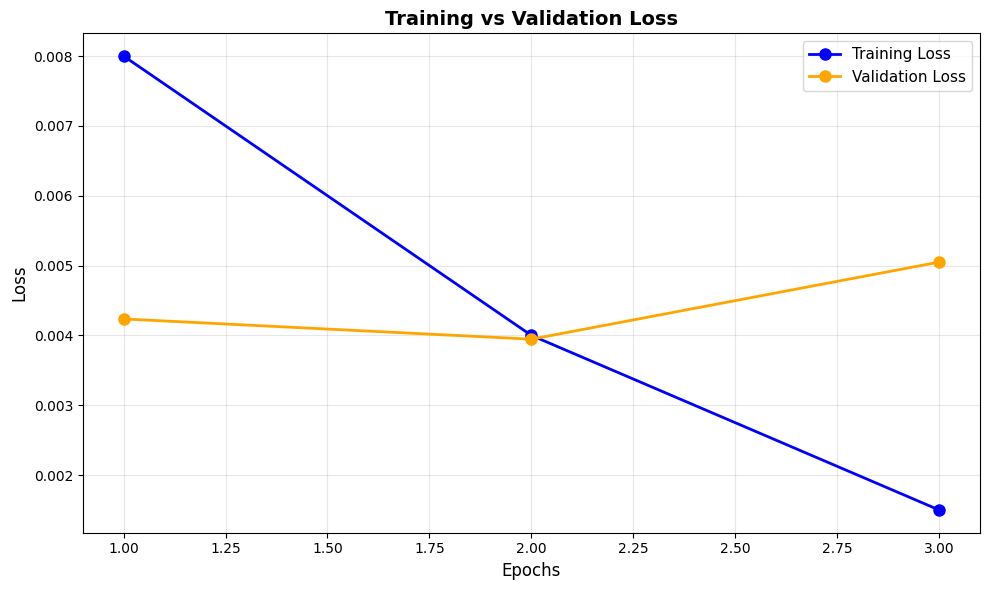

Plot saved as 'training_validation_loss.png'


In [ ]:
epochs = [1, 2, 3]
train_loss = [0.0080, 0.0040, 0.0015]
val_loss = [0.004236, 0.003946, 0.005050]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss', linewidth=2, markersize=8)
plt.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss', linewidth=2, markersize=8)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Evaluate the model performance on test dataset
test_result = trainer.evaluate(test_dataset)

/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
print(f"\nTest Results:")
print(f"Accuracy:  {test_result['eval_accuracy']:.4f}")
print(f"F1 Score:  {test_result['eval_f1']:.4f}")
print(f"Precision: {test_result['eval_precision']:.4f}")
print(f"Recall:    {test_result['eval_recall']:.4f}")


Test Results:
Accuracy:  0.9986
F1 Score:  0.9986
Precision: 0.9972
Recall:    1.0000


In [ ]:
## Model evaluation on test dataset
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = preds_output.label_ids


/tmp/ipython-input-2407297667.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipython-input-2407297667.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
cm = confusion_matrix(y_true, y_pred)

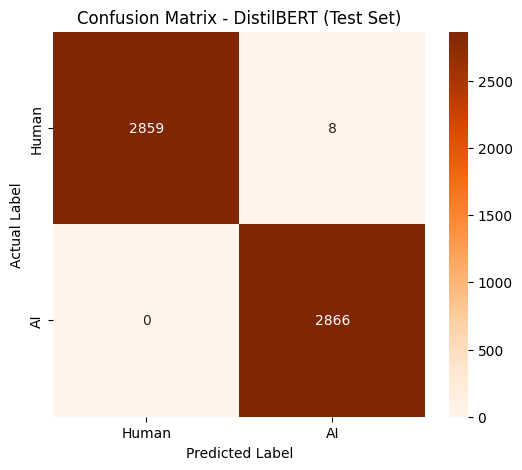

In [ ]:
# plot confusion matrix for test set
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Human','AI'], yticklabels=['Human','AI'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix - DistilBERT (Test Set)')
plt.show()